<a href="https://colab.research.google.com/github/jkorgu/C4145CW/blob/main/CE4145cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Section One - Dataset__

By Jakub Olbrisch - Student Number: 2106944

<br>

## __Dataset Information__

The dataset is called "rotten_tomatoes" and it is provided by "cornell-movie-review-data" which was published on the website "huggingface".

The dataset itself is a collection of 10,662 rotten tomatoes movie reviews, split into 2 categories of positive and negative, labeled 1 and 0 respectively.

Furthermore, the dataset splits into "train", "validation" and "test" files which I manually undo and redo.

<br>

## __Task to be performed__

The task performed in this coursework is text classification with the main goal of being able to predict the appropriate label as output through the content of the text within the review as input.

Gemini was used for 1 or 2 error messages at one point and was enabelled for the first few commits, should be disabled and the gemini-assisted areas may not even exist anymore.

In [1]:
#possible layouts
#1 dataset
#1.1 dataset exploration
#1.1.1 basic data exploration (shape, head, missing values) DONE
#1.1.2 class distribution (label per split, 3 bar graphs to confirm what was said earlier about dataset) DONEs
#1.2 preprocessing - merge validation and test before preproc proper
#2 representation learning
#3 algorithms
#3.1 tuning?
#3.2 model comparison - bar graph?
#4 evaluation
#4.1 result interpretation?

## 1.1 Dataset Exploration

In this section we will be exploring the dataset to confirm its shape, size and other factors to ensure it matches the description given online.

### 1.1.1 Basic Data Exploration

Here we will look at these parts of the dataset:
- Shape
- Samples of the data (df.head())
- Check for missing values

__52 words total from both sections (165 total)__

In [2]:
#importing some basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#import dataset from huggingface, splits are already decided on the website, as seen below with our seperate dataframes
splits = {'train': 'train.parquet', 'validation': 'validation.parquet', 'test': 'test.parquet'}
dfTrain = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["train"])
dfValidation = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["validation"])
dfTest = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
#Shape of the training dataset
print(f'dfTrain has {dfTrain.shape[0]} rows, and {dfTrain.shape[1]} columns')
print(f'dfValidation has {dfValidation.shape[0]} rows, and {dfValidation.shape[1]} columns')
print(f'dfTest has {dfTest.shape[0]} rows, and {dfTest.shape[1]} columns')
print(f'Total rows of the entire dataset: {dfTrain.shape[0]+dfValidation.shape[0]+dfTest.shape[0]}')

dfTrain has 8530 rows, and 2 columns
dfValidation has 1066 rows, and 2 columns
dfTest has 1066 rows, and 2 columns
Total rows of the entire dataset: 10662


In [5]:
#Missing valuees check - should have none
print(f'dfTrain missing values:\n{dfTrain.isnull().sum()}')
print(f'dfValidation missing values:\n{dfValidation.isnull().sum()}')
print(f'dfTest missing values:\n{dfTest.isnull().sum()}')

dfTrain missing values:
text     0
label    0
dtype: int64
dfValidation missing values:
text     0
label    0
dtype: int64
dfTest missing values:
text     0
label    0
dtype: int64


In [6]:
#Show the training data, both positive and negative entries (confirming text and label columns too)
dfTrain.head(-5)

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8520,"the star who helped give a spark to "" chasing ...",0
8521,a summary of the plot doesn't quite do justice...,0
8522,every conceivable mistake a director could mak...,0
8523,"snoots will no doubt rally to its cause , trot...",0


### 1.1.2 Class Distribution

Confirming through plots even class distribution

<Axes: title={'center': 'dfTest positive/negative review split'}, xlabel='label', ylabel='count'>

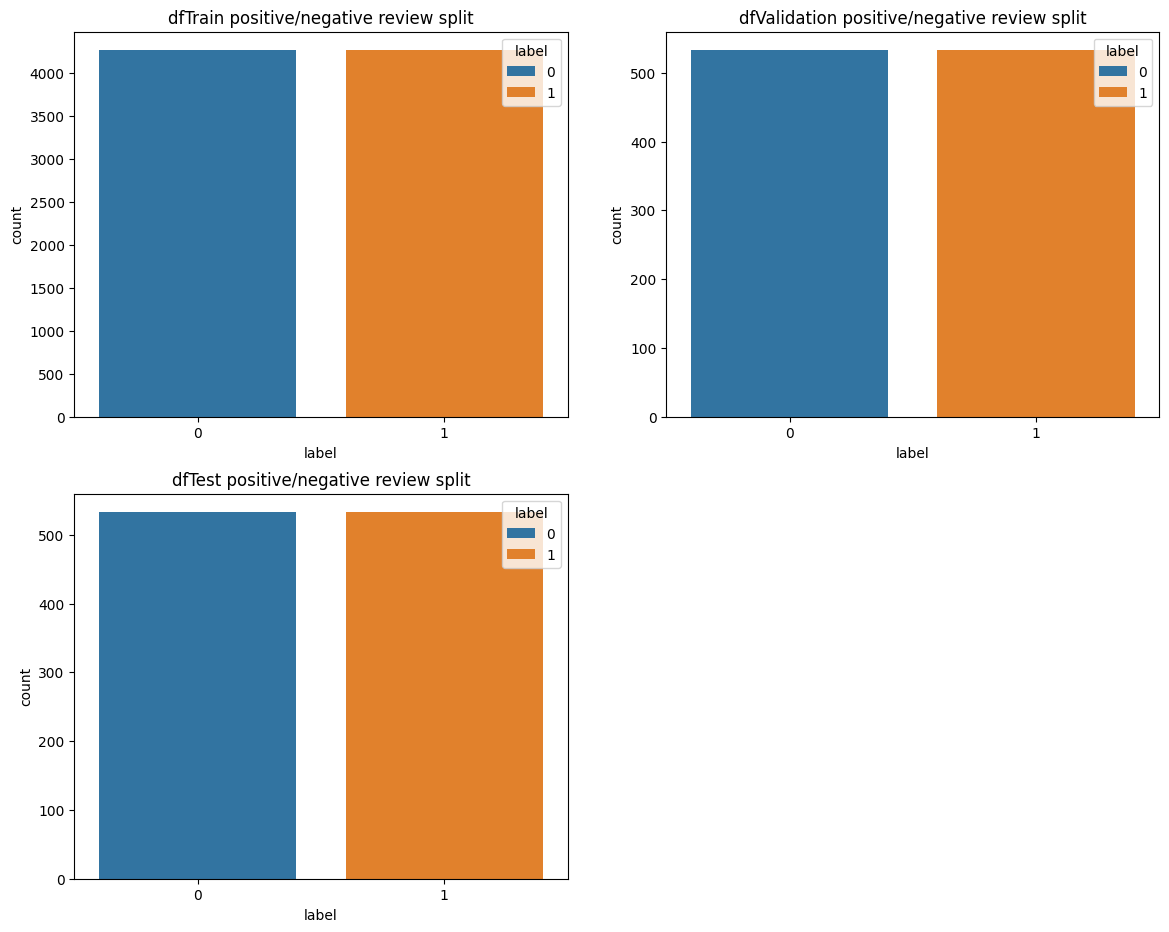

In [7]:
#make 3 subplots - one for each data-split
plt.figure(figsize=(14,11))
#First subplot                  - dfTrain
plt.subplot(2,2,1)
plt.title('dfTrain positive/negative review split')
sns.countplot(x='label', data=dfTrain, hue='label')
#Second subplot                 - dfValidation
plt.subplot(2,2,2)
plt.title('dfValidation positive/negative review split')
sns.countplot(x='label', data=dfValidation, hue='label')
#Third subplot                  - dfTest
plt.subplot(2,2,3)
plt.title('dfTest positive/negative review split')
sns.countplot(x='label', data=dfTest, hue='label')

## 1.2 Preprocessing

In [8]:
#merged everything
dfMerged = [dfTrain, dfValidation, dfTest]
dfFull = pd.concat(dfMerged)
dfFull.shape

(10662, 2)

<Axes: title={'center': 'dfFull positive/negative review split'}, xlabel='label', ylabel='count'>

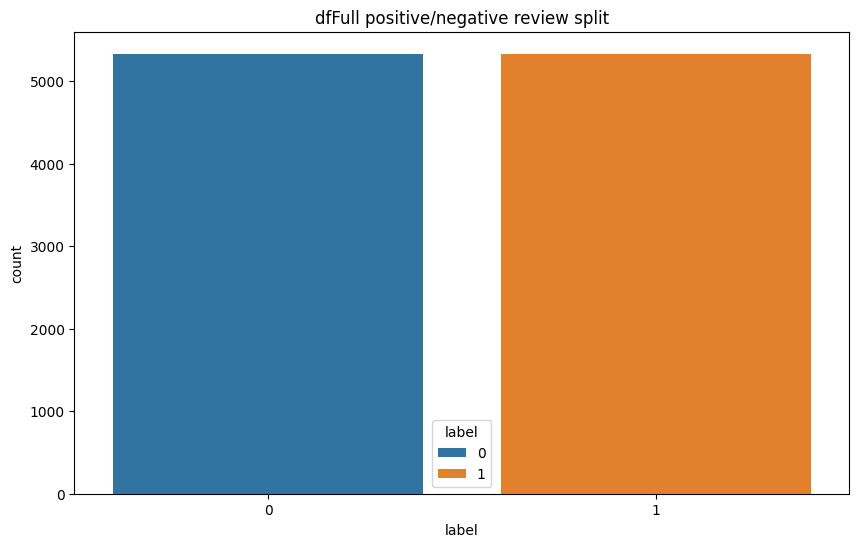

In [9]:
#plot new dataframe to ensure even label split
plt.figure(figsize=(10,6))
plt.title('dfFull positive/negative review split')
sns.countplot(data=dfFull, x='label', hue='label')

In [10]:
#balance check (choose between this method or plots, ASK KYLE)
print(dfFull['label'].value_counts())

label
1    5331
0    5331
Name: count, dtype: int64


In [11]:
#Converting into numpy arrays

x = dfFull['text'].to_numpy()
y = dfFull['label'].to_numpy()

#test
#print(x)
#print(y)

For pre-processing I chose to use tokenisation alongside a lemmatizer, from initial testing I found that stemming took away too much from the words, whilst a lemmatizer keeps a better output.

In [12]:
#import nltk functionalities alongside sklearn functionalities
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def prep(X):
    prepText = []
    for x in X:
      tokenText = word_tokenize(x) #tokenize data
      normdText = [token.lower() for token in tokenText] #simple cleaning by lowercase casting

      swrd = stopwords.words('english') #stopwords is saved as an object
      swrdText = [token for token in normdText if token not in swrd]

      lemm = WordNetLemmatizer() #lemmatize - want to keep full meaning of words
      prepText += [[lemm.lemmatize(word) for word in swrdText]]

    #join it all back together
    prepSentences = [' '.join(sentence) for sentence in prepText]
    return prepSentences


#processed data
procx = prep(x)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
print(procx[0])

rock destined 21st century 's new `` conan `` 's going make splash even greater arnold schwarzenegger , jean-claud van damme steven segal .


#Section Two - Representation Learning

glove

In [14]:
#this takes like 2minutes
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-28 01:04:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 40s  

2025-11-28 01:07:19 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [16]:
#load pretrained glove
def loadGlove(path="glove.6B.300d.txt"):
  embeddings = {}
  with open(path, 'r', encoding='utf8') as f:
    for line in f:
      parts = line.strip().split()
      word = parts[0]
      vector = np.array(parts[1:], dtype='float32')
      embeddings[word] = vector
  return embeddings

glove = loadGlove('glove.6B.300d.txt')

#convert the sentence into a glove embedded one
def gloveRep(sentence, glove_dict, emb_size=300):
  embs = [glove_dict[word] for word in sentence if word in glove_dict]
  sentEmb = np.mean(np.array(embs), axis=0)
  return sentEmb

#Section Three - Algorithms

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lrAccScore = []
rfAccScore = []

kf = StratifiedKFold(n_splits=5)
npx = np.array(procx)

for train, test in kf.split(npx,y):

  x_train, x_test, y_train, y_test = npx[train], npx[test], y[train], y[test]

  #convert sentences using glove
  x_trainGlove = [gloveRep(sentence, glove) for  sentence in x_train]
  x_testGlove = [gloveRep(sentence, glove) for sentence in x_test]

  #logistic regression algorithm
  lr = LogisticRegression(max_iter=500)
  lr.fit(x_trainGlove, y_train)
  lrPred = lr.predict(x_testGlove)
  #accuracy
  lrAcc = accuracy_score(lrPred, y_test)
  #accuracyappended
  lrAccScore.append(lrAcc)

  #random forest algorithm
  rf = RandomForestClassifier(n_estimators=200)
  rf.fit(x_trainGlove, y_train)
  rfPred = rf.predict(x_testGlove)
  #accuracy
  rfAcc = accuracy_score(rfPred, y_test)
  #accuracy
  rfAccScore.append(rfAcc)

print("Logistic Regression Score:\n Accuracy:", np.mean(lrAcc))
print("Random Forest Score:\n Accuracy:", np.mean(rfAcc))

Logistic Regression Score:
 Accuracy: 0.5703564727954972
Random Forest Score:
 Accuracy: 0.5576923076923077


#Section Four - Evaluation